In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import geopandas as gpd
from glob import glob

In [3]:
sys.path.insert(1,'../../scripts/03_plant_optimization/')

In [4]:
import plant_optimization as pop
from plant_optimization.notebook_tools import *

In [5]:
europe_grid = gpd.read_file('../../results_samples/Europe_Evaluation_Grid.shp')
europe_grid.rename(columns={'grid_lat':'lat','grid_lon':'lon'},inplace=True)
europe_borders = gpd.read_file('../../results_samples/Europe_WGS84.shp')

In [6]:
results_path = os.path.join('../../results/02_plant_optimization') # Points to the location of the results csv files

In [7]:
countries = ['Switzerland','Austria']
results = pd.DataFrame()
for country in countries:
    df = pd.DataFrame()
    for file_glob in glob(f'{results_path}/{country}*.csv'): 
        df = df.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df['country'] = country
    results = results.append(df)

In [8]:
results_gdf = gpd.GeoDataFrame(results.merge(europe_grid.rename(columns={'name':'country'}),on=['lat','lon','country'],how='left'))

In [9]:
def plot_results(data,countries,metrics,figsize=(25,20),ncols=None,fontsize=None,cmap=None,vmax=None,missing_kwds=None,legend_kwds={}):
    if ncols == None:
        ncols = int(np.ceil(np.sqrt(len(metrics))))
    nrows = int(np.ceil(len(metrics)/ncols))
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    axes = np.reshape(axes,(1,nrows*ncols))[0]

    if fontsize == None:
        fontsize = figsize[0]*2
    df = data.loc[data.country.isin(countries)].copy()
    borders = europe_borders.loc[europe_borders.country.isin(countries)].copy()
    for i,(metric,description) in enumerate(metrics.items()):
        if metric not in ['turbine_type','specific_capacity_class']:
            l_kwds = legend_kwds.copy()
            l_kwds.setdefault('orientation','horizontal')
            l_kwds['ax'] = axes[i]
            l_kwds.pop('bbox_to_anchor',None)
            l_kwds.pop('fontsize',None)
        else:
            l_kwds = legend_kwds.copy()
            l_kwds.pop('orientation',None)
            l_kwds.setdefault('loc','upper center')
            l_kwds.setdefault('ncol',min(3,df[metric].nunique()))
            l_kwds.setdefault('fontsize',fontsize*.75)
            
            if df[metric].nunique()>10:
                cmap = 'tab20'
        df.plot(column=metric,legend=True,cmap=cmap,vmax=vmax,missing_kwds=missing_kwds,legend_kwds=l_kwds,ax=axes[i])
        borders.boundary.plot(color='k',ax=axes[i])
        cb_ax = axes[i].figure.axes[-1]
        cb_ax.tick_params(labelsize=fontsize)
        axes[i].axis('off')
        axes[i].set_title(description,fontsize=fontsize)
#     plt.tight_layout()

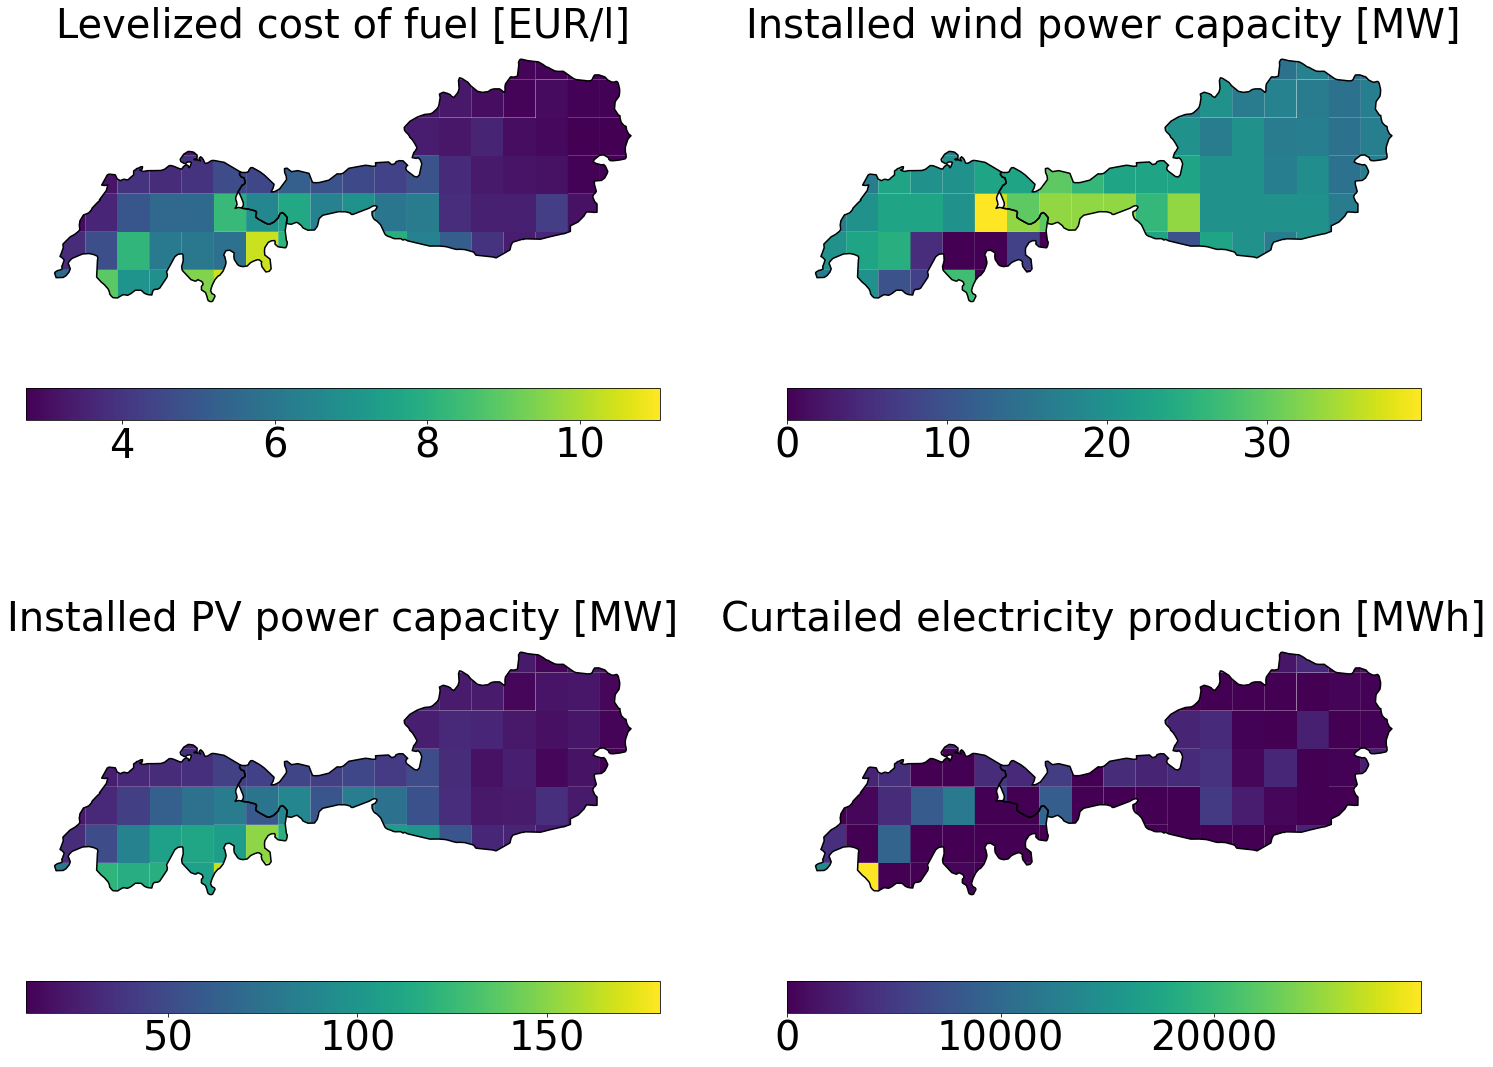

In [10]:
data = results_gdf.copy()
countries = ['Switzerland','Austria']
metrics = {'LCOF_liter':'Levelized cost of fuel [EUR/l]',
           'wind_capacity_MW':'Installed wind power capacity [MW]',
           'PV_capacity_MW':'Installed PV power capacity [MW]',
           'curtailed_el_MWh':'Curtailed electricity production [MWh]'}
fontsize = 40
plot_results(data=data,countries=countries,metrics=metrics,fontsize=fontsize)

# Investigate high curtailed electricity

In [51]:
results_gdf.sort_values('curtailed_el_MWh',ascending=False).head(3)

,lat,lon,turbine_type,rotor_diameter,rated_turbine_power,wind_turbines,wind_capacity_MW,PV_capacity_MW,electrolyzer_capacity_MW,CO2_capture_tonph,...,PV_production_MWh,NPV_EUR,CAPEX_EUR,LCOF_MWh,LCOF_liter,runtime,country,PV_lat,PV_lon,geometry
50,47.5,10.625,N131/3300,131.0,3300.0,10.0,33.0,32.862530,14.276032,2.053427,...,26089.293703,1.317408e+08,8.061807e+07,804.649227,7.688870,1110.636494,Austria,47.390128,10.659047,"POLYGON ((10.93750 47.46889, 10.93750 47.25000..."
7,46.5,6.250,N131/3300,131.0,3300.0,7.0,23.1,23.527501,11.974207,1.221147,...,30478.994253,9.712394e+07,6.211337e+07,593.215669,5.668505,1008.013400,Switzerland,46.528093,6.329267,"POLYGON ((6.42015 46.75000, 6.56250 46.75000, ..."
6,46.0,10.000,GE120/2500,120.0,2500.0,9.0,22.5,148.706301,23.033372,2.207753,...,145623.739466,3.681098e+08,2.703777e+08,2248.348945,21.484223,432.779653,Switzerland,46.239057,10.098074,"POLYGON ((10.04078 46.25000, 10.15876 46.25000..."


In [62]:
country = 'Austria'
point = (47.5,10.625)
site = pop.Site(point,country)
plant = pop.Plant(site)
plant.operation = pd.read_parquet(f'../../results/02_plant_optimization/operation/{country}_{point[0]}_{point[1]}.parquet.gzip')
plant.operation.head()

,wind_production_kWh,PV_production_kWh,battery_chr_kWh,battery_dis_kWh,battery_state_kWh,H2stor_chr_kWh,H2stor_dis_kWh,H2stor_state_kWh,CO2stor_chr_kg,CO2stor_dis_kg,...,H2_el_kWh,CO2_el_kWh,H2tL_el_kWh,heat_el_kWh,battery_flow_kWh,H2_production_kWh,CO2_consumption_kg,CO2_production_kg,CO2stor_flow_kg,fuel_production_kWh
time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:30:00,0.000000,0.0,0.0,254.831973,550.988050,9.995834e+06,1.000000e+07,69216.976394,9.999378e+06,1.000000e+07,...,0.000000,254.831973,0.0,0.0,-254.831973,0.000000,159891.75673,159269.983129,-621.7736,1221.395576
2016-01-01 01:30:00,0.000000,0.0,0.0,254.831973,275.494025,0.000000e+00,4.165566e+03,65051.410616,9.999378e+06,1.000000e+07,...,0.000000,254.831973,0.0,0.0,-254.831973,0.000000,159891.75673,159269.983129,-621.7736,1221.395576
2016-01-01 02:30:00,459.361453,0.0,0.0,0.000000,0.000000,0.000000e+00,4.042848e+03,60885.844838,9.999378e+06,1.000000e+07,...,204.529480,254.831973,0.0,0.0,0.000000,122.717688,159891.75673,159269.983129,-621.7736,1221.395576
2016-01-01 03:30:00,2076.424904,0.0,0.0,0.000000,0.000000,0.000000e+00,3.072610e+03,56842.996747,0.000000e+00,6.217736e+02,...,1821.592931,254.831973,0.0,0.0,0.000000,1092.955759,159891.75673,159269.983129,-621.7736,1221.395576
2016-01-01 04:30:00,4427.816467,0.0,0.0,0.000000,0.000000,9.998338e+06,1.000000e+07,53770.386728,0.000000e+00,6.217736e+02,...,4172.984494,254.831973,0.0,0.0,0.000000,2503.790697,159891.75673,159269.983129,-621.7736,1221.395576


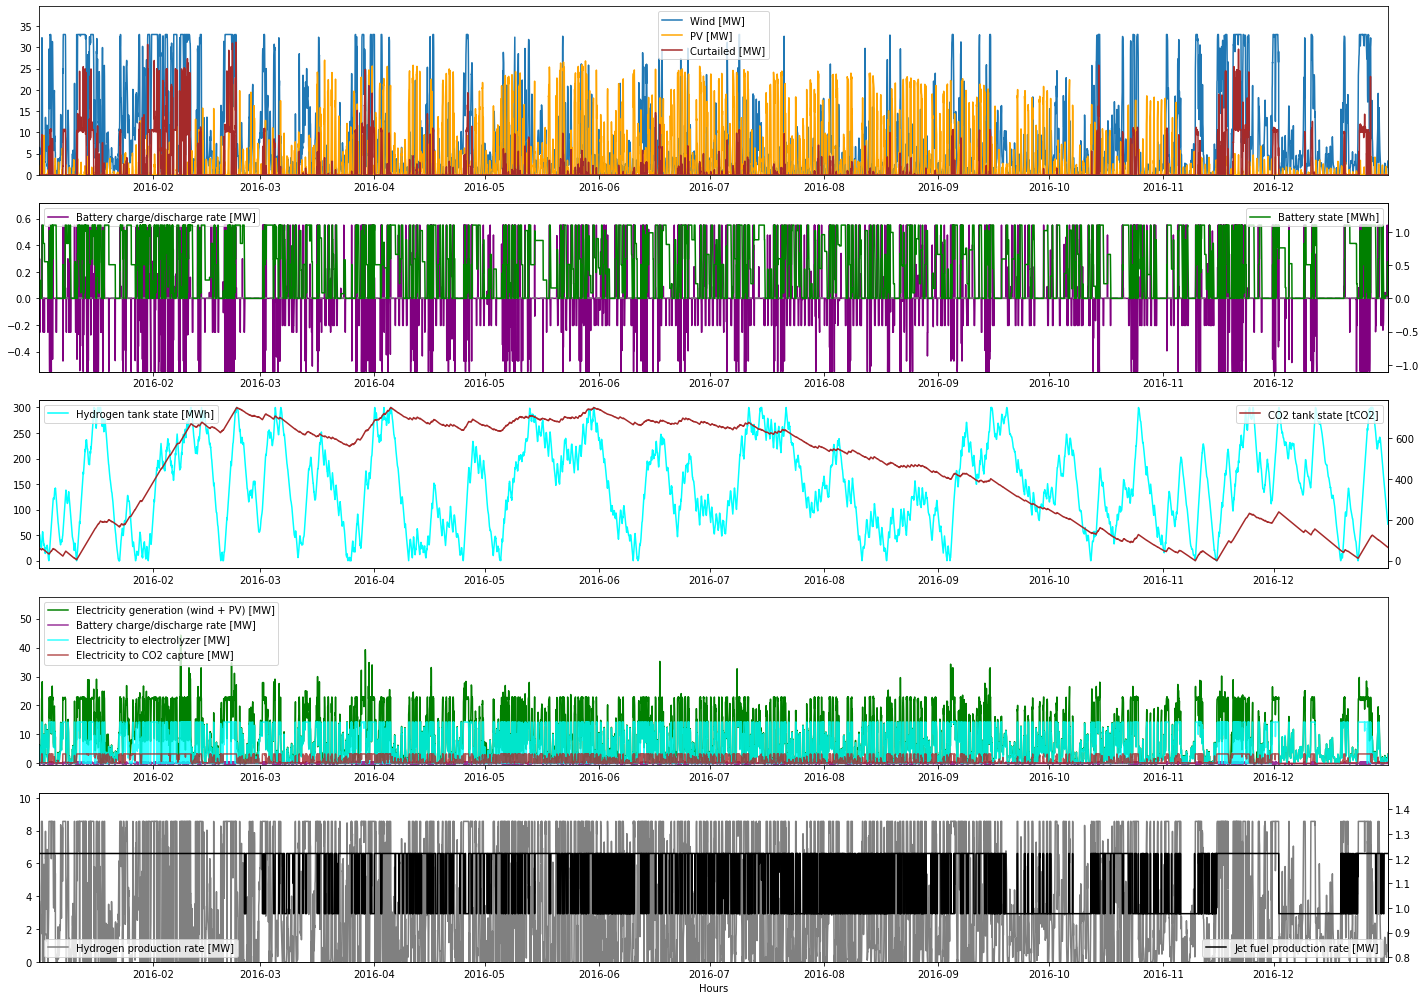

In [63]:
plot_plant_operation(plant)

AttributeError: 'DataFrame' object has no attribute 'site'

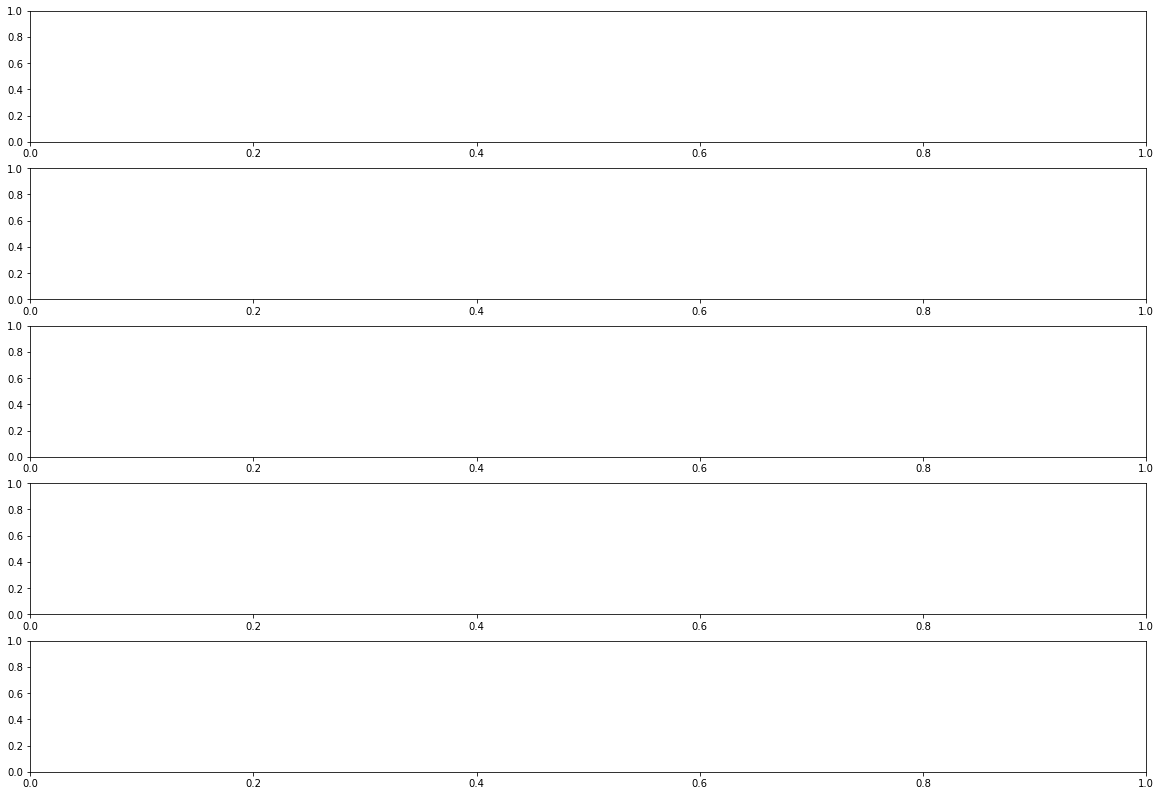